In [16]:
import pandas as pd
import torch
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, f1_score

In [9]:
df = pd.read_csv("IMDB-Dataset.csv")  # Adjust path as needed
df['sentiment'] = df['sentiment'].map({'positive': 1, 'negative': 0})  # Binary labels
df

,review,sentiment
0,One of the other reviewers has mentioned that ...,1
1,A wonderful little production. <br /><br />The...,1
2,I thought this was a wonderful way to spend ti...,1
3,Basically there's a family where a little boy ...,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",1
...,...,...
49995,I thought this movie did a down right good job...,1
49996,"Bad plot, bad dialogue, bad acting, idiotic di...",0
49997,I am a Catholic taught in parochial elementary...,0
49998,I'm going to have to disagree with the previou...,0


In [7]:
X_train, X_test, y_train, y_test = train_test_split(
    df['review'], df['sentiment'], test_size=0.2, random_state=42
)

In [8]:
vectorizer = CountVectorizer(ngram_range=(1, 2))  # unigram + bigram
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

## This is our baseline, Multinomial Naive Bayes model using unigrams and bigrams

In [14]:
model = MultinomialNB()
model.fit(X_train_vec, y_train)

MultinomialNB()

In [17]:
y_pred = model.predict(X_test_vec)

accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Accuracy: {accuracy:.4f}")
print(f"F1 Score: {f1:.4f}")

Accuracy: 0.8829
F1 Score: 0.8818


## Now, we want to try adding TF-IDF Features

In [51]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(ngram_range=(1, 2))

In [52]:
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

In [53]:
model = MultinomialNB()
model.fit(X_train_vec, y_train)

y_pred = model.predict(X_test_vec)

accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"TF-IDF Accuracy: {accuracy:.4f}")
print(f"TF-IDF F1 Score: {f1:.4f}")

TF-IDF Accuracy: 0.8892
TF-IDF F1 Score: 0.8867


### Summary: Switching to TF-IDF improved both accuracy and F1 score, indicating better generalization and reduced noise from frequent but less informative terms.

## Now that we have MNB and TF-IDF with bigrams, we can also extract the top predictive features from the trained MultinomialNB model

In [54]:
import numpy as np

# Get feature names and class log probabilities
feature_names = np.array(vectorizer.get_feature_names_out())
log_prob = model.feature_log_prob_

# Top 20 features most indicative of positive sentiment
top_pos_idx = np.argsort(log_prob[1])[-20:]
top_pos_features = feature_names[top_pos_idx]

# Top 20 features most indicative of negative sentiment
top_neg_idx = np.argsort(log_prob[0])[-20:]
top_neg_features = feature_names[top_neg_idx]

print("Top Positive Features:")
print(top_pos_features[::-1])  # reverse for descending order

print("\nTop Negative Features:")
print(top_neg_features[::-1])

Top Positive Features:
['the' 'and' 'of' 'br' 'to' 'is' 'it' 'in' 'this' 'that' 'br br' 'as'
 'film' 'movie' 'was' 'you' 'with' 'for' 'of the' 'but']

Top Negative Features:
['the' 'br' 'and' 'to' 'of' 'it' 'is' 'this' 'in' 'that' 'movie' 'was'
 'br br' 'film' 'you' 'but' 'for' 'as' 'with' 'not']


### There is too many overlaps in the words, and many words are not meaningful. Let's avoid that by accounting for English stopwords

In [55]:
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

pos_scores = log_prob[1]
neg_scores = log_prob[0]

N = 10000
top_pos_idx = np.argsort(pos_scores)[-N:]
top_neg_idx = np.argsort(neg_scores)[-N:]

top_pos = set(feature_names[top_pos_idx])
top_neg = set(feature_names[top_neg_idx])

# Remove overlaps and stopwords
distinct_pos = [f for f in top_pos - top_neg if f not in ENGLISH_STOP_WORDS and len(f) > 2]
distinct_neg = [f for f in top_neg - top_pos if f not in ENGLISH_STOP_WORDS and len(f) > 2]

# Sort by original score
distinct_pos_sorted = sorted(distinct_pos, key=lambda f: pos_scores[vectorizer.vocabulary_[f]], reverse=True)[:20]
distinct_neg_sorted = sorted(distinct_neg, key=lambda f: neg_scores[vectorizer.vocabulary_[f]], reverse=True)[:20]

print("Top Distinctive Positive Features:")
print(distinct_pos_sorted)

print("\nTop Distinctive Negative Features:")
print(distinct_neg_sorted)

Top Distinctive Positive Features:
['loved it', 'highly recommend', 'is excellent', '10 10', 'well worth', 'wonderfully', 'is wonderful', 'is perfect', 'with great', 'it great', 'great job', 'loved this', 'well written', 'highly recommended', 'first saw', 'friendship', 'is must', 'enjoyed this', 'delightful', 'finest']

Top Distinctive Negative Features:
['waste of', 'your time', 'worst movie', 'pointless', 'pathetic', 'waste your', 'laughable', 'bad acting', 'really bad', 'is bad', 'don waste', 'redeeming', 'boring and', 'sucks', 'worse than', 'bad the', 'how bad', 'sit through', 'worst movies', 'avoid this']


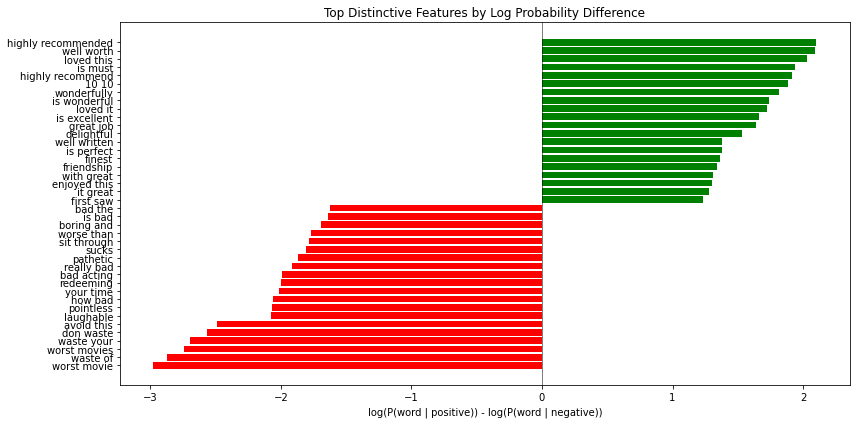

In [56]:
import matplotlib.pyplot as plt

# Compute score differences
feature_diffs = {
    f: pos_scores[vectorizer.vocabulary_[f]] - neg_scores[vectorizer.vocabulary_[f]]
    for f in distinct_pos_sorted + distinct_neg_sorted
}

# Select top 20 positive and negative by difference
sorted_diffs = sorted(feature_diffs.items(), key=lambda x: x[1])

top_20_neg = sorted_diffs[:20]
top_20_pos = sorted_diffs[-20:]

# Combine for plotting
features = [f for f, _ in top_20_neg + top_20_pos]
scores = [s for _, s in top_20_neg + top_20_pos]

# Plot
plt.figure(figsize=(12, 6))
plt.barh(features, scores, color=['red']*20 + ['green']*20)
plt.axvline(0, color='black', linewidth=0.5)
plt.title("Top Distinctive Features by Log Probability Difference")
plt.xlabel("log(P(word | positive)) - log(P(word | negative))")
plt.tight_layout()
plt.show()

In [57]:
trusted_keywords = set(distinct_pos_sorted + distinct_neg_sorted)

vectorizer = TfidfVectorizer(ngram_range=(1, 2))
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

feature_names = vectorizer.get_feature_names_out()
trusted_indices = [i for i, f in enumerate(feature_names) if f in trusted_keywords]

In [58]:
from scipy.sparse import csr_matrix

# Boost factor
boost = 2.0

# Create a copy to modify
X_train_boosted = X_train_vec.copy()
X_test_boosted = X_test_vec.copy()

# Apply boost to selected columns
X_train_boosted[:, trusted_indices] *= boost
X_test_boosted[:, trusted_indices] *= boost

In [60]:
model = MultinomialNB()
model.fit(X_train_boosted, y_train)

y_pred = model.predict(X_test_boosted)

accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Accuracy (with keyword boost): {accuracy:.4f}")
print(f"F1 Score (with keyword boost): {f1:.4f}")

Accuracy (with keyword boost): 0.8913
F1 Score (with keyword boost): 0.8891


### 📊 Model Performance Comparison

| Model                                | Accuracy | F1 Score |
|-------------------------------------|----------|----------|
| MNB + CountVectorizer (unigrams + bigrams) | 0.8829   | 0.8818   |
| MNB + TF-IDF (unigrams + bigrams)   | 0.8892   | 0.8867   |
| + Keyword Boosting                  | 0.8913   | 0.8891   |

### Summary: introduced a keyword boosting mechanism that increases the influence of sentiment-specific words identified from the model itself. The addition of keyword boosting yielded a modest but meaningful improvement in both accuracy and F1 score. This shows that guiding the model’s attention to discriminative words can enhance its effectiveness without increasing model complexity.